# Human Activity Recognition with Keras 

> https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

> https://github.com/ni79ls/har-keras-cnn

- 1dCNN (One-dimensional Convolutional Neural Networks)
- input: 3-d acceleration data (W x 3)
- initial kernel: L x 3
- first activation: (W-L+1, N), N is the number of neurons in the first hidden layer
- next kernel: L x 1
- Pooling: Max or GlobalAveraging

> HAR : 
- 6 labels: 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'

## Data set
> [WISDM data set](http://www.cis.fordham.edu/wisdm/dataset.php)

### Statistics
- Raw Time Series Data
    - Number of examples: 1,098,207
    - Number of attributes: 6
    - Missing attribute values: None
- Class Distribution
    - Walking: 424,400 (38.6%)
    - Jogging: 342,177 (31.2%)
    - Upstairs: 122,869 (11.2%)
    - Downstairs: 100,427 (9.1%)
    - Sitting: 59,939 (5.5%)
    - Standing: 48,395 (4.4%)

### Transformed Examples
- Number of transformed examples: 5,424
- Number of transformed attributes: 46
- Missing attribute values: None
- Class Distribution
    - Walking: 2,082 (38.4%)
    - Jogging: 1,626 (30.0%)
    - Upstairs: 633 (11.7%)
    - Downstairs: 529 (9.8%)
    - Sitting: 307 (5.7%)
    - Standing: 247 (4.6%)

In [1]:
# !pip install sklearn  # 20190404

In [2]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.utils import np_utils
print("Keras ver. = ", keras.__version__)

Using TensorFlow backend.


Keras ver. =  2.2.4


In [3]:
# functions

# def feature_normalize(dataset):

#     mu = np.mean(dataset, axis=0)
#     sigma = np.std(dataset, axis=0)
#     return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe

    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview

    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file

    Args:
        file_path: URL pointing to the CSV file

    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column of the type 'str' must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [4]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

keras version  2.2.4


In [5]:
# Parameters of data
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

In [6]:
# Load data & preprocessing

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('data_har/WISDM_ar_v1.1_raw.txt')

# Describe the data
show_basic_dataframe_info(df, 10)


--- Load, inspect and transform data ---

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

   user-id activity       timestamp  x-axis  y-axis  z-axis
0       33  Jogging  49105962326000    -0.7    12.7     0.5
1       33  Jogging  49106062271000     5.0    11.3     1.0
2       33  Jogging  49106112167000     4.9    10.9    -0.1
3       33  Jogging  49106222305000    -0.6    18.5     3.0
4       33  Jogging  49106332290000    -1.2    12.1     7.2
5       33  Jogging  49106442306000     1.4    -2.5    -6.5
6       33  Jogging  49106542312000    -0.6    10.6     5.7
7       33  Jogging  49106652389000    -0.5    13.9     7.1
8       33  Jogging  49106762313000    -8.4    11.4     5.1
9       33  Jogging  49106872299000     1.0     1.4     1.6

Description of dataframe:



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user-id      1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [8]:
df['activity'].mode()  # most frequent activity

0    Walking
dtype: object

In [9]:
df['activity'].value_counts(),df['activity'].value_counts().sum()

(Walking       424397
 Jogging       342176
 Upstairs      122869
 Downstairs    100427
 Sitting        59939
 Standing       48395
 Name: activity, dtype: int64, 1098203)

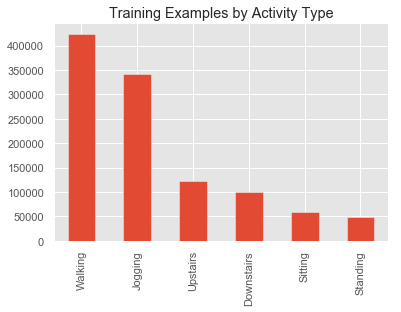

In [10]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

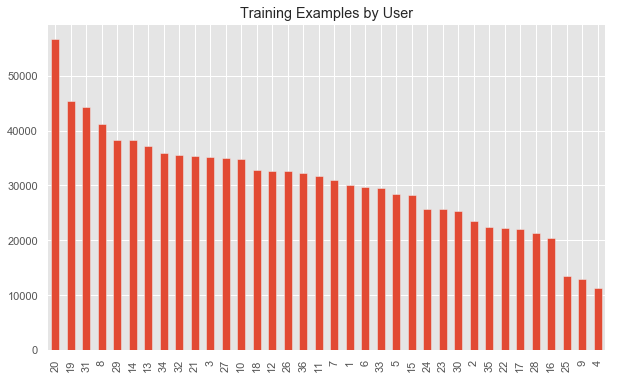

In [11]:
df['user-id'].value_counts().plot(kind='bar', figsize=(10,6),
                                  title='Training Examples by User')
plt.show()

In [12]:
np.unique(df["activity"])

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

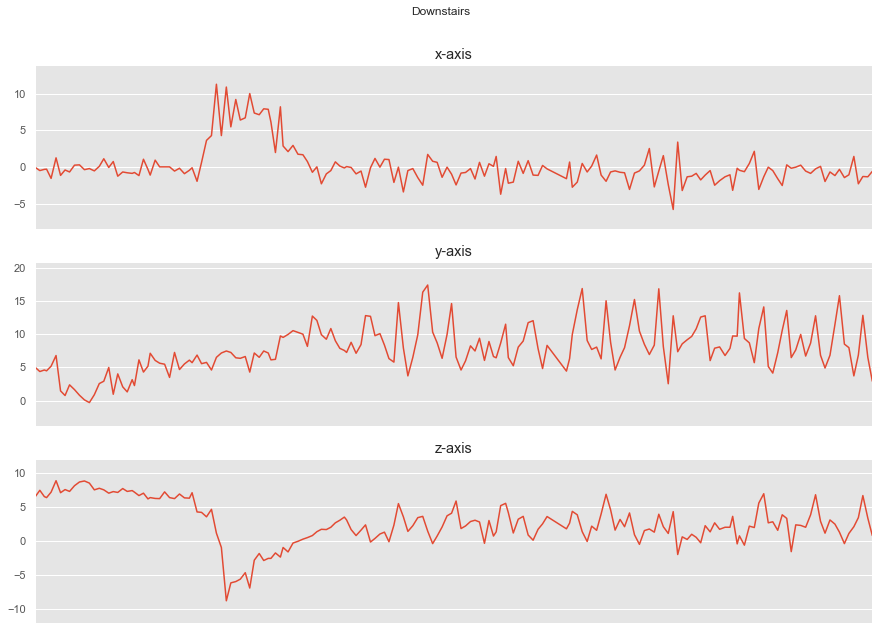

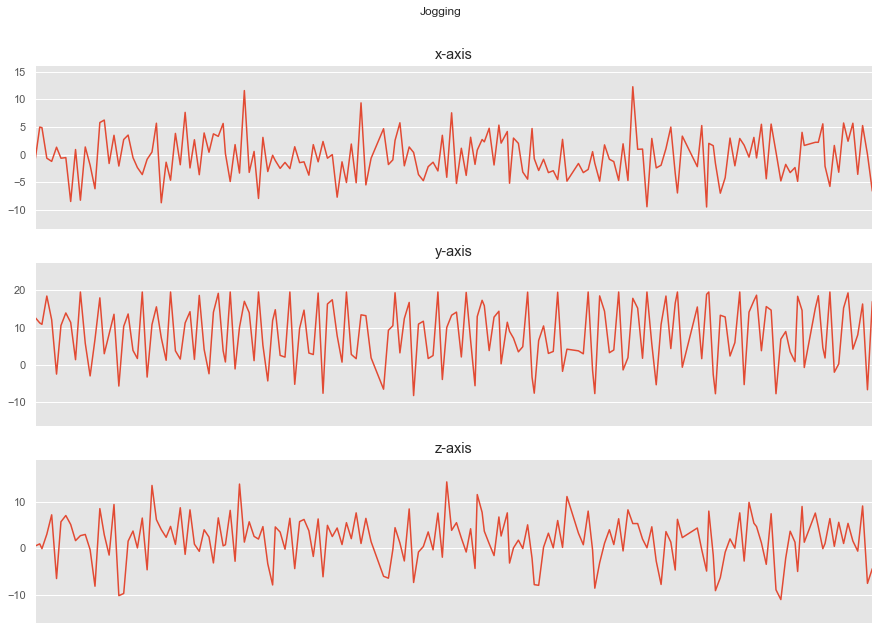

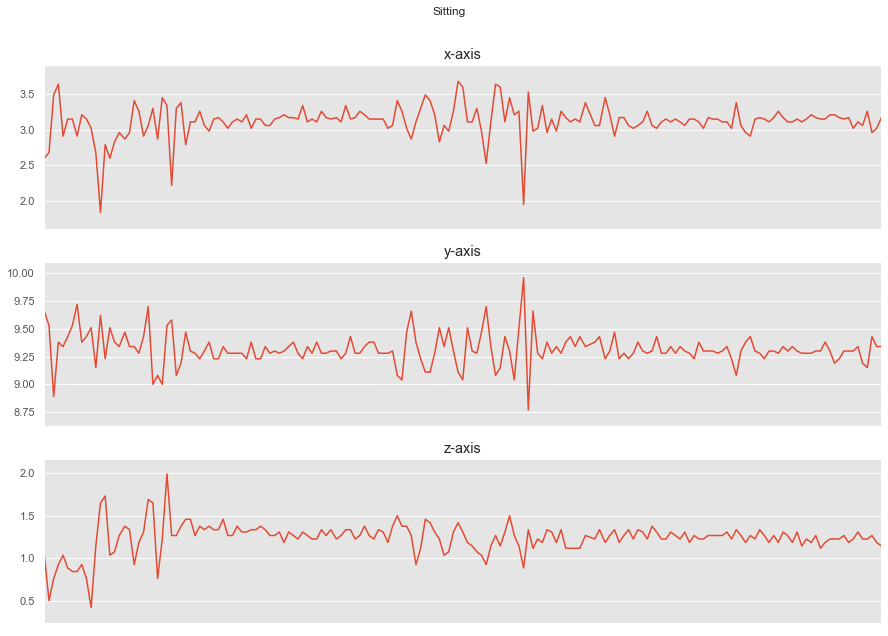

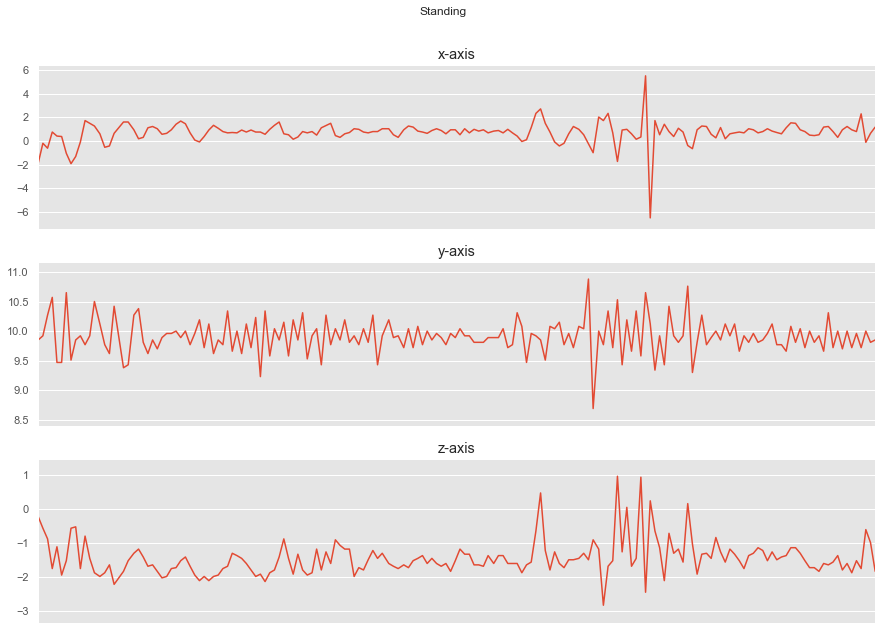

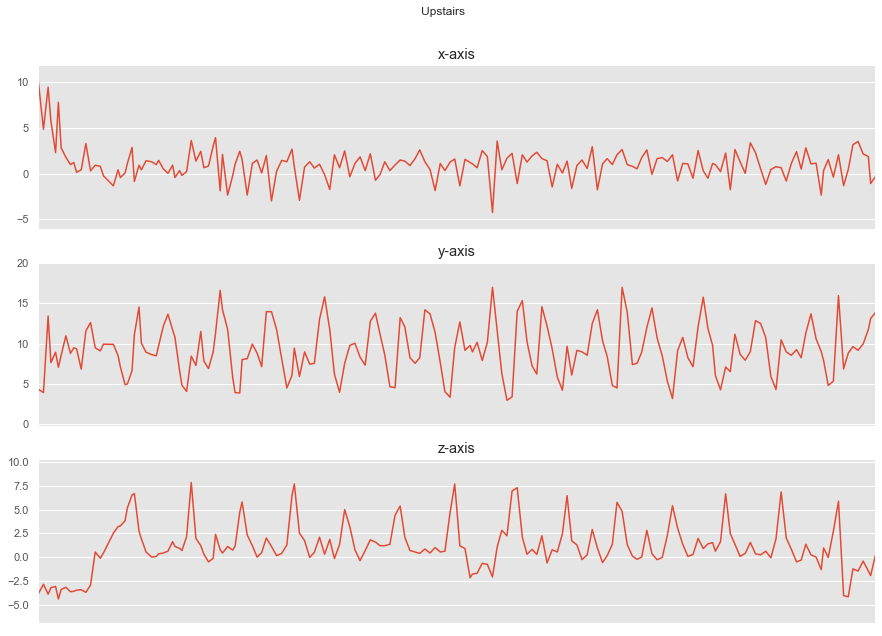

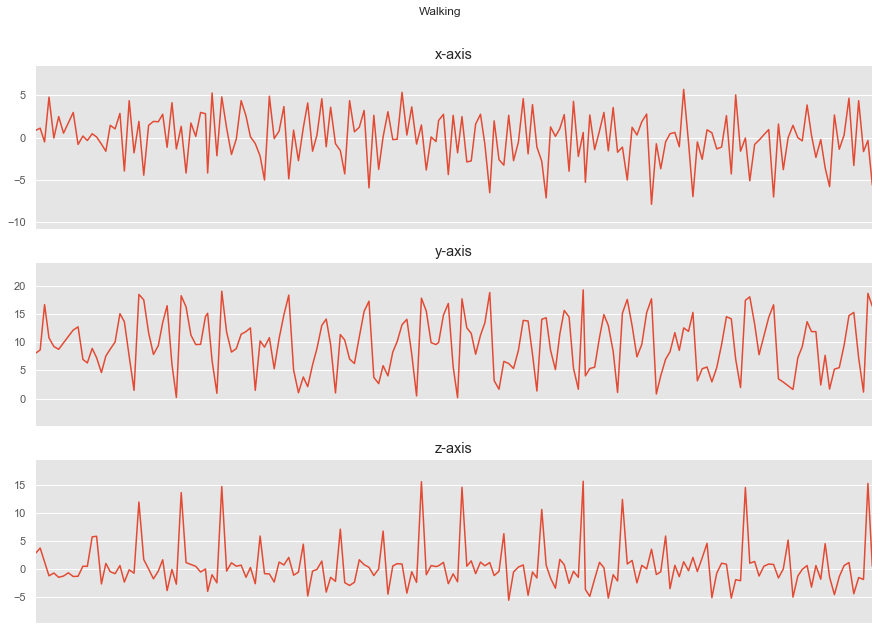

In [13]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 7 columns):
user-id            1098203 non-null int64
activity           1098203 non-null object
timestamp          1098203 non-null int64
x-axis             1098203 non-null float64
y-axis             1098203 non-null float64
z-axis             1098203 non-null float64
ActivityEncoded    1098203 non-null int32
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 62.8+ MB


In [15]:
df.head(10)

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1
5,33,Jogging,49106442306000,1.4,-2.5,-6.5,1
6,33,Jogging,49106542312000,-0.6,10.6,5.7,1
7,33,Jogging,49106652389000,-0.5,13.9,7.1,1
8,33,Jogging,49106762313000,-8.4,11.4,5.1,1
9,33,Jogging,49106872299000,1.0,1.4,1.6,1


In [16]:
# Reshape data & split train and test set
print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_train = df[df['user-id'] <= 28]
df_test = df[df['user-id'] > 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])


--- Reshape the data into segments ---



c:\anaconda3\envs\tfjs\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\anaconda3\envs\tfjs\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\anaconda3\envs\tfjs\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [17]:
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834780 entries, 8489 to 1098203
Data columns (total 7 columns):
user-id            834780 non-null int64
activity           834780 non-null object
timestamp          834780 non-null int64
x-axis             834780 non-null float64
y-axis             834780 non-null float64
z-axis             834780 non-null float64
ActivityEncoded    834780 non-null int32
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 47.8+ MB


In [19]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,-0.0,0.4,-0.2,5
8490,17,Walking,57870012316000,-0.1,0.4,-0.2,5
8491,17,Walking,57870122301000,-0.1,0.4,-0.2,5
8492,17,Walking,57870222246000,-0.1,0.4,-0.2,5
8493,17,Walking,57870332292000,-0.1,0.4,-0.2,5


In [20]:
# Reshape the training data into segments
# so that they can be processed by the network
# TIME_PERIODS=80, STEP_DISTANCE=40
X_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

# %%

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect X data
print('X_train shape: ', X_train.shape)
# Displays (20869, 40, 3)
print(X_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)


--- Reshape data to be accepted by Keras ---

X_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [21]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_time_periods, num_sensors

(80, 3)

In [22]:
num_classes = le.classes_.size
print(list(le.classes_),num_classes)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'] 6


In [23]:
# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
X_train = X_train.reshape(X_train.shape[0], input_shape)

print('X_train shape:', X_train.shape)
# X_train shape: (20869, 120), (20868, 240)
print('input_shape:', input_shape)
# input_shape: (120) (240)

X_train shape: (20868, 240)
input_shape: 240


In [24]:
# Convert type for Keras otherwise Keras cannot process the data
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")

In [25]:
# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6), (20868, 6)

New y_train shape:  (20868, 6)


In [26]:
from IPython.core.display import HTML, Image

## 1dCNN
> [1dCNN](https://keras.io/layers/convolutional/#conv1d)

- 1D Convolutions with 2D input 

> Eventhough input is 2D ex) 20x14 
output-shape is not 2D , but 1D Matrix
because filter height = L must be matched with input height = L
- 1-direction (x) to calcuate conv! not 2D
- L is the number of channels
- **input = [W,L], filter = [k,L] output = [W-k+1]**
- output-shape is 1D Matrix

> what if we want to train N filters (N is number of filters)
then output shape is (stacked 1D) 2D = 1D x N matrix.  
[link: 1d-2d-and-3d-convolutions](https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n)

![1dCNN](./image/d1CNN.png)

<img src="./image/d1CNN.png" width=50% height=50%/>

In [27]:
TIME_PERIODS,num_sensors

(80, 3)

In [28]:
# ANN: 1d CNN
# TIME_PERIODS=80, num_sensors=3
print("\n--- Create neural network model: 1dCNN ---\n")
n_k = 8  # dim of kernel: 4, 6, 8, 10, ...
# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, n_k, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, n_k, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, n_k, activation='relu'))
model_m.add(Conv1D(160, n_k, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())



--- Create neural network model: 1dCNN ---

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 73, 100)           2500      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 66, 100)           80100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 160)           128160    
__________________________________________

In [29]:
# Accuracy on training data: 99%
# Accuracy on test data: 91%

# %%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])


--- Fit the model ---



In [30]:
# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

# %%

Instructions for updating:
Use tf.cast instead.
Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 12s 711us/step - loss: 0.8275 - acc: 0.6924 - val_loss: 0.5536 - val_acc: 0.8055
Epoch 2/50
16694/16694 [==============================] - 12s 697us/step - loss: 0.4034 - acc: 0.8492 - val_loss: 0.5413 - val_acc: 0.8129
Epoch 3/50
16694/16694 [==============================] - 12s 697us/step - loss: 0.3002 - acc: 0.8942 - val_loss: 0.4821 - val_acc: 0.8515
Epoch 4/50
16694/16694 [==============================] - 12s 701us/step - loss: 0.2219 - acc: 0.9248 - val_loss: 0.5321 - val_acc: 0.8285
Epoch 5/50
16694/16694 [==============================] - 12s 699us/step - loss: 0.2001 - acc: 0.9312 - val_loss: 0.6478 - val_acc: 0.8141
Epoch 6/50
16694/16694 [==============================] - 12s 700us/step - loss: 0.1684 - acc: 0.9457 - val_loss: 0.6435 - val_acc: 0.7997
Epoch 7/50
16694/16694 [==============================] - 11s 687us/s


--- Learning curve of model training ---



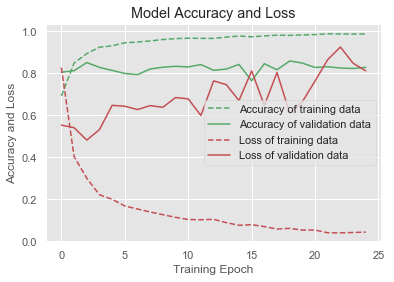

In [31]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [32]:
#%% Test data

print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

X_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
X_test = X_test.reshape(X_test.shape[0], input_shape)

X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(X_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])


--- Check against test data ---



c:\anaconda3\envs\tfjs\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\anaconda3\envs\tfjs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\anaconda3\envs\tfjs\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

6584/6584 [==============================] - 2s 235us/step

Accuracy on test data: 0.91

Loss on test data: 0.42



--- Confusion matrix for test data ---



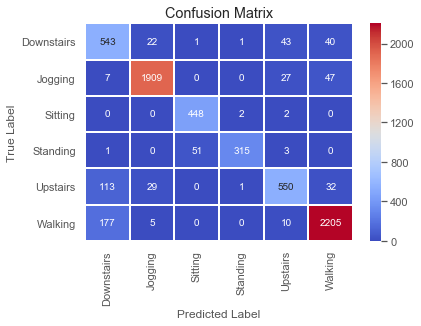


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       650
           1       0.97      0.96      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.99      0.85      0.91       370
           4       0.87      0.76      0.81       725
           5       0.95      0.92      0.93      2397

   micro avg       0.91      0.91      0.91      6584
   macro avg       0.89      0.89      0.88      6584
weighted avg       0.92      0.91      0.91      6584



In [33]:
# %%
# 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))
# 'Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'